In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.autograd as autograd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
print(device)


cuda


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def filterLong(pairs):
    pairList = []
    MAX_LENGTH = 10
    for i in range(len(pairs)):
        if(len(pairs[i])>1):
          sent0 = pairs[i][0]
          sent1 = pairs[i][1]
          
        if(" " in sent0):
            temoSent0 = sent0.split(" ")
        if(" " in sent1):
            temoSent1 = sent1.split(" ")

        if((len(temoSent0) <= MAX_LENGTH) and (len(temoSent1) <= MAX_LENGTH)):
          pairList.append(pairs[i])
    return pairList

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/drive/My Drive/translate/questions_answers_ubuntu.txt').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [20]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterLong(pairs)
    twoConv = []
    for i in range(len(pairs)):
        if(len(pairs[i]) >1):
            twoConv.append(pairs[i])


    pairs = filterPairs(twoConv)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        if(len(pair) > 1):
          input_lang.addSentence(pair[0])
          output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'gar', True)
print(random.choice(pairs))

Reading lines...
Read 969572 sentence pairs
Trimmed to 2738 sentence pairs
Counting words...
Counted words:
gar 1528
eng 1413
['nto yet having reached my best before date', 'i m still immature i m sure']


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        #print("coming here")
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        #embedded = self.dropout(embedded)
        #print("Embd size-->",embedded.size)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
## With attention

teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # if use_teacher_forcing:
    #     # Teacher forcing: Feed the target as the next input
    #     for di in range(target_length):
    #         decoder_output, decoder_hidden, decoder_attention = decoder(
    #             decoder_input, decoder_hidden, encoder_outputs)
    #         loss += criterion(decoder_output, target_tensor[di])
    #         decoder_input = target_tensor[di]  # Teacher forcing

    # else:
        # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=10, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    #return plot_losses

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]



        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1], encoder_outputs 

In [0]:
def evaluateRandomlyTranslate(encoder, decoder, n=100):
    encoder_outputs = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions, en_out = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

        #print(en_out)
        # maxVal = max(en_out)
        # minVal = min(en_out)

        # print("Max value->",maxVal)
        # print("Min value->",minVal)   

        encoder_outputs.append(en_out)

    return encoder_outputs

1m 1s (- 14m 27s) (5000 6%) 2.4107
2m 2s (- 13m 19s) (10000 13%) 2.1481
3m 9s (- 12m 37s) (15000 20%) 1.8025
4m 19s (- 11m 54s) (20000 26%) 1.3309
5m 33s (- 11m 6s) (25000 33%) 0.8546
6m 49s (- 10m 13s) (30000 40%) 0.5281
8m 6s (- 9m 16s) (35000 46%) 0.3220
9m 24s (- 8m 14s) (40000 53%) 0.2138
10m 42s (- 7m 8s) (45000 60%) 0.1731
12m 0s (- 6m 0s) (50000 66%) 0.1574
13m 19s (- 4m 50s) (55000 73%) 0.1604
14m 37s (- 3m 39s) (60000 80%) 0.1458
15m 56s (- 2m 27s) (65000 86%) 0.1459
17m 15s (- 1m 13s) (70000 93%) 0.1346
18m 34s (- 0m 0s) (75000 100%) 0.1217


<Figure size 432x288 with 0 Axes>

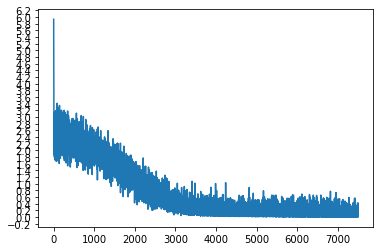

In [33]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)






In [34]:

torch.save(encoder1.state_dict(), '/content/drive/My Drive/translate/encoder_tran_en_de_new_qus_ans_ubuntu.dict.th')
torch.save(attn_decoder1.state_dict(), '/content/drive/My Drive/translate/decoder_with_attention_tran_en_de_new_qus_ans_ubuntu.dict')
encoder_outputs = evaluateRandomlyTranslate(encoder1, attn_decoder1)

> isn t his router ip . ?
= i am aware
< i am aware <EOS>

> i am brazilian
= i am pt
< i am pt <EOS>

> why ?
= you re going to regret that
< i re looking streets regret flash <EOS>

> ok think i gonna try them
= they are really good
< they are really good <EOS>

> hullo
= i m off now as havn t instaled
< i m off now as havn t instaled <EOS>

> thx so i propably got broken iso img
= i m running it now
< i m running it now <EOS>

> i have no idea about what to download
= i m sure it is available
< i m sure it is available <EOS>

> hello
= we are
< we am using in irc <EOS>

> your like . . . ?
= you are gay like anal sex with other men
< you are gay like anal sex with other men <EOS>

> any error messages ?
= i m a linux newbie . . .
< i m a linux newbie . . . <EOS>

> why is that ?
= i am not very pleased with ubuntu
< i am not very pleased with ubuntu <EOS>

>  !iso obi 
= i m just not sure which options to use
< i m just not sure which options to use <EOS>

> what does dmesg tail say

In [36]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
encoder1.load_state_dict(torch.load('/content/drive/My Drive/translate/encoder_tran_en_de_new_qus_ans_ubuntu.dict.th'))
attn_decoder1.load_state_dict(torch.load('/content/drive/My Drive/translate/decoder_with_attention_tran_en_de_new_qus_ans_ubuntu.dict'))

<All keys matched successfully>

In [0]:
class Block(nn.Module):

    def __init__(self, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(block_dim, block_dim),
            nn.ReLU(True),
            nn.Linear(block_dim, block_dim),
        )

    def forward(self, x):
        return self.net(x) + x


class Generator(nn.Module):

    def __init__(self, n_layers, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            *[Block(block_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.net(x)


class Critic(nn.Module):

    def __init__(self, n_layers, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            *[Block(block_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.net(x)

In [0]:
n_layers = 20
block_dim = 256
gp_lambda = 10
latent_dim = 256
interval = 1000
batch_size = 1
n_critic = 100
generator = Generator(n_layers, block_dim)
critic = Critic(n_layers, block_dim)
critic.to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
c_optimizer = optim.Adam(critic.parameters(), lr=1e-4)

In [0]:
def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    alpha = alpha.to(device)
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    sample = sample.to(device)
    score = critic(sample)
    outputs = torch.FloatTensor(B, 256).fill_(1.0)
    outputs.requires_grad_(False)
    outputs = outputs.to(device)
 
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    #grads = grads.view(B, -1)
    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()

    return grad_penalty

In [0]:
def train(epoch):


    generator = Generator(n_layers, block_dim)
    generator.to(device)
    critic = Critic(n_layers, block_dim)
    critic.to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
    c_optimizer = optim.Adam(critic.parameters(), lr=1e-4)
    
    encoder1.eval()
    attn_decoder1.eval()
    generator.train()
    critic.train()

    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    hidden_size = 256
    max_length = 10

    for i in range(len(pairs)):
      pair = pairs[i]
      sentence = pair[0]

      input_tensor = tensorFromSentence(input_lang, sentence)
      input_length = input_tensor.size()[0]

      encoder_hidden = encoder1.initHidden()
      encoder_outputs = torch.zeros(input_length, encoder1.hidden_size, device=device)
        
      decoder_output = torch.zeros(max_length, latent_dim, device=device)

      fc3 = nn.Linear(encoder1.hidden_size, latent_dim)
      fc3.to(device)

      with torch.no_grad():
          for ei in range(input_length):
              encoder_output, encoder_hidden = encoder1(input_tensor[ei], encoder_hidden)
              encoder_outputs[ei] += encoder_output[0, 0]

      encoder_outputs = fc3(encoder_outputs)
      c_optimizer.zero_grad()

      noise = torch.from_numpy(np.random.normal(0, 1, (input_length, latent_dim))).float()
      noise = noise.to(device)

      z_fake = generator(noise)        
      z_fake.to(device)

      real_score = critic(encoder_outputs)
      fake_score = critic(z_fake)
      grad_penalty = compute_grad_penalty(critic, encoder_outputs.data, z_fake.data)
      
      c_loss = -torch.mean(real_score) + torch.mean(fake_score) + gp_lambda * grad_penalty
      c_train_loss += c_loss.item()
      c_loss.backward()
      c_optimizer.step()



      # train generator
      if i % n_critic == 0:
          g_batches += 1
          g_optimizer.zero_grad()
          fake_score = critic(generator(noise))
          g_loss = -torch.mean(fake_score)
          g_train_loss += g_loss.item()
          g_loss.backward()
          g_optimizer.step()

      if interval > 0 and i % interval == 0:
          print('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
              epoch, batch_size * i, len(pairs),
                      100. * (batch_size * i) / len(pairs),
              g_loss.item(), c_loss.item()
          ))

    print("End of loop ====>>>>>")
    g_train_loss /= g_batches
    c_train_loss /= len(pairs)
    print('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f}'.format(
        epoch, g_train_loss, c_train_loss
    ))
    return (g_train_loss, c_train_loss)

In [44]:
best_loss = np.inf
epochs = 10
for epoch in range(1, epochs + 1):
    g_loss, c_loss = train(epoch)
    loss = g_loss + c_loss
    if loss < best_loss:
        best_loss = loss
        print('* Saved')
        torch.save(generator.state_dict(), '/content/drive/My Drive/translate/generator_question_answer_ubuntu.th')
        torch.save(critic.state_dict(), '/content/drive/My Drive/translate/critic_question_answer_ubuntu.th')

Epoch: 1 | Batch: 0/2738 (0%) | G Loss: 0.200958 | C Loss: 6350.701660
Epoch: 1 | Batch: 1000/2738 (37%) | G Loss: -0.079259 | C Loss: 5.721465
Epoch: 1 | Batch: 2000/2738 (73%) | G Loss: -0.058214 | C Loss: 0.532286
End of loop ====>>>>>
* (Train) Epoch: 1 | G Loss: -0.0450 | C Loss: 28.2302
* Saved
Epoch: 2 | Batch: 0/2738 (0%) | G Loss: 0.047730 | C Loss: 6641.666016
Epoch: 2 | Batch: 1000/2738 (37%) | G Loss: -0.090551 | C Loss: 6.843675
Epoch: 2 | Batch: 2000/2738 (73%) | G Loss: -0.057204 | C Loss: 2.255315
End of loop ====>>>>>
* (Train) Epoch: 2 | G Loss: -0.0557 | C Loss: 28.6908
Epoch: 3 | Batch: 0/2738 (0%) | G Loss: -0.170604 | C Loss: 6781.441895
Epoch: 3 | Batch: 1000/2738 (37%) | G Loss: -0.114652 | C Loss: 4.123209
Epoch: 3 | Batch: 2000/2738 (73%) | G Loss: -0.083017 | C Loss: 1.358951
End of loop ====>>>>>
* (Train) Epoch: 3 | G Loss: -0.0847 | C Loss: 31.0343
Epoch: 4 | Batch: 0/2738 (0%) | G Loss: -0.007825 | C Loss: 6561.869629
Epoch: 4 | Batch: 1000/2738 (37%) | G

In [0]:
def testGan(encoder, decoder, sentence, max_length=10):
    with torch.no_grad():
        #print("1")
        input_length = sentence.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        encoder_outputs[0: input_length,:] = sentence

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        #print("2")
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            #print("3")
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
from numpy.random import randint

def evaluateGAN(encoder, decoder, encoder_outputs, n=100):
    latent_dim = 256
    n_layers = 20
    block_dim = 256
    output_sentence_list = []
    while(len(output_sentence_list) < 100):
        generator = Generator(n_layers, block_dim)
        generator.eval()
        generator.load_state_dict(torch.load('/content/drive/My Drive/translate/generator_question_answer_ubuntu.th', map_location='cpu'))
        input_tensor = [[85],[86],[109],[1362],[2],[6],[1]]
        input_tensor = torch.from_numpy(np.asarray(input_tensor)).float()
        noise = torch.from_numpy(np.random.normal(loc = 0.7, scale = 1, size = (10,256)))
        
        #noise = torch.from_numpy(input_tensor).float()
        #z = generator(noise)
        #print("Z shape=",z.shape)
        #print("z=", z)
        pair = random.choice(pairs)
        #print('>', pair[0])
        #print('=', pair[1])
        #print(noise)
        #output_words, attentions = testGan(encoder, decoder, encoder_outputs[i])
        output_words, attentions = testGan(encoder, decoder, noise)
        #output_words, attentions = testGan(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)

        if(output_sentence not in output_sentence_list and len(output_sentence.split(" "))>6):
            output_sentence_list.append(output_sentence)
            print('<', output_sentence)
            print('')

In [76]:
evaluateGAN(encoder1,attn_decoder1, encoder_outputs)

< i m in the same thing ? <EOS>

< i m using linux right now <EOS>

< i m in the same thing <EOS>

< i m in to do . <EOS>

< i m a linux newbie . <EOS>

< i m in to do now <EOS>

< i m in the wrong problem <EOS>

< i m in to a problem <EOS>

< i m in the same i <EOS>

< i m in the same thing . <EOS>

< i m using linux right ? <EOS>

< i m an to do . <EOS>

< i m in the wrong channel <EOS>

< i m sorry to do . <EOS>

< i m from to play this <EOS>

< i m in the ntfs  <EOS>

< i m in the wrong of <EOS>

< i m using xchat do now <EOS>

< i m in the same i think <EOS>

< i m in the same . <EOS>

< i m using linux do ? <EOS>

< i m in the same i folder <EOS>

< i m using xchat my desktop <EOS>

< i m in to play this <EOS>

< i m in the same i do <EOS>

< i m in the same i thing <EOS>

< i m an linux right now <EOS>

< i m in network right now <EOS>

< i m here to play . <EOS>

< i m an to play this <EOS>

< i m in the as havn <EOS>

< i m in the same i do ? <EOS>

< i m using linux right now